# Raw data to training images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Data normalization

In this notebook, we demonstrate how to save the original raw data into an image format without losing pixel information. The demonstration will be done on 200x200 region of DAS data, which can be loaded using the `h5py` library. DAS measurements are saved as 16-bit unsigned integer values, meaning that minimum and maximum values recordable is −32,768 and 32,767.

In [15]:
import h5py
with h5py.File('/content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180104001631_ch4650_4850.mat','r') as f:
    data = f[f.get('variable/dat')[0,0]][:200,11000:11200]
print(data)

[[ 133.  114.  106. ...   92.  166.   75.]
 [ 138.   82.   58. ...  127.  181.   12.]
 [ 128.  -12.    0. ...  194.  229.  -61.]
 ...
 [   5.   37.   57. ...   45.   70.  -46.]
 [  16.   66.   43. ...   19.  179. -100.]
 [-112.   78.   31. ...   22.  115.  -76.]]


Below we show how the raw data looks like. We use the "seismic" color map to visualize the region, this is usually how domain experts plot the data as one can really differentiate regions where waves are stretching (red positive amplitudes) or compressing (blue negative amplitudes) the fiber-optic cable.

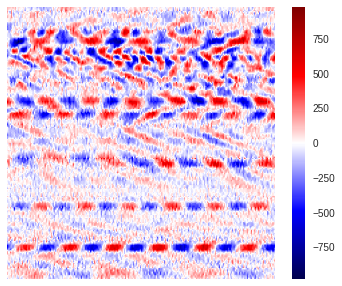

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(6,5))
plt.imshow(data,aspect='auto',cmap='seismic',vmin=-abs(data).max(),vmax=abs(data).max())
plt.colorbar()
plt.axis("off")
plt.show()

However, when the region is saved into an image and used for training, it is common practice to normalize its values between 0 and 1, so as to avoid overloading the memory usage.

In [17]:
data_norm = (data-data.min())/(data.max()-data.min())
print(data_norm)

[[0.60140617 0.59113034 0.58680368 ... 0.57923202 0.61925365 0.57003786]
 [0.60411033 0.57382369 0.5608437  ... 0.59816117 0.62736614 0.53596539]
 [0.598702   0.5229854  0.52947539 ... 0.63439697 0.65332612 0.49648459]
 ...
 [0.53217956 0.54948621 0.56030287 ... 0.55381287 0.56733369 0.50459708]
 [0.53812872 0.56517036 0.55273121 ... 0.53975122 0.62628448 0.4753921 ]
 [0.46890211 0.57166036 0.54624121 ... 0.54137372 0.59167117 0.48837209]]


The difference between negative and positive values is then lost and the standard way to visualize the normalized region is through a grayscale format. We note that why the amplitude information is lost, the embedded features present in the region are still there. Therefore, from a computer vision standpoint, the main characteristics of the  data that are useful for deep learning applications remain available. Below is how the normalized region looks like using a standard grayscale color mapping.

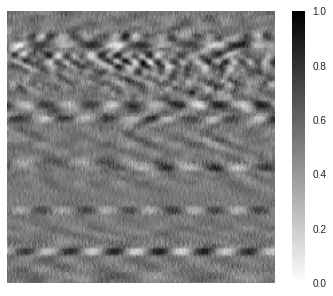

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(6,5))
plt.imshow(data_norm,aspect='auto',cmap='binary')
plt.colorbar()
plt.axis("off")
plt.show()

## Image representation

### 8-bit original implementation

Here we explain the first version of how images were saved. The feature is still available, though kept optional, so we can reproduce any past results that were produced using this approach. In this versin, the data are saved as 8-bit JPG images with unsigned integer values from 0 to 255. The above normalized array can therefore be re-normalized to have pixel values between 0 and 255.

In [19]:
import numpy
info = numpy.iinfo(numpy.uint8)
print(info)
data_uint8 = numpy.uint8(data_norm*info.max)
print(data_uint8)

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

[[153 150 149 ... 147 157 145]
 [154 146 143 ... 152 159 136]
 [152 133 135 ... 161 166 126]
 ...
 [135 140 142 ... 141 144 128]
 [137 144 140 ... 137 159 121]
 [119 145 139 ... 138 150 124]]


The key issue here is the loss of data that is caused by saving the original 16-bit signed raw values into an 8-bit unsigned image. Below we show the normalized values from the saved image. As one can notice, the values are different then the actual normalized array from the raw data.

In [20]:
image = (data_uint8-data_uint8.min())/(data_uint8.max()-data_uint8.min())
print(image)

[[0.6        0.58823529 0.58431373 ... 0.57647059 0.61568627 0.56862745]
 [0.60392157 0.57254902 0.56078431 ... 0.59607843 0.62352941 0.53333333]
 [0.59607843 0.52156863 0.52941176 ... 0.63137255 0.65098039 0.49411765]
 ...
 [0.52941176 0.54901961 0.55686275 ... 0.55294118 0.56470588 0.50196078]
 [0.5372549  0.56470588 0.54901961 ... 0.5372549  0.62352941 0.4745098 ]
 [0.46666667 0.56862745 0.54509804 ... 0.54117647 0.58823529 0.48627451]]


In the figure below, we show the difference between the original normalized array and the one recovered from the 8-bit saved image. A mean difference of 0.002 is found between both arrays. It is difficult to assess whether this is of real importance for machine learning, however, it is always recommended to get the best fidelity. Better accuracy during saving can be achieved using 16-bit PNG image format.

Mean difference: 0.0019615609391403954


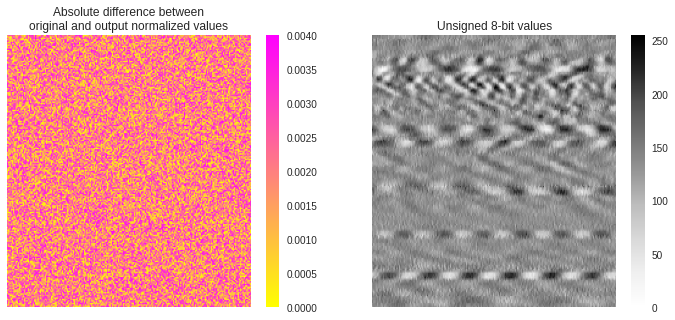

In [40]:
import matplotlib.pyplot as plt
print('Mean difference:',numpy.mean(abs(image-data_norm)))
plt.style.use('seaborn')
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
img = ax1.imshow(abs(image-data_norm),aspect='auto',cmap='spring_r',vmax=4e-3)
plt.colorbar(img,ax=ax1)
ax1.set_title('Absolute difference between\noriginal and output normalized values')
ax1.axis("off")
img = ax2.imshow(data_uint8,aspect='auto')
plt.colorbar(img,ax=ax2)
ax2.set_title('Unsigned 8-bit values')
ax2.axis("off")
plt.show()

### 16-bit enhanced fidelity

Since the data are saved into signed 16-bit values, the data original normalized data should therefore be saved into unsigned 16-bit Portable Network Graphics (PNG) image. The normalized array can be re-normalized using values between 0 and 65,535 (the maximum value for unsigned 16-bit integer format).

In [41]:
import numpy
from PIL import Image
info = numpy.iinfo(numpy.uint16)
print(info)
data_uint16 = numpy.uint16(data_norm*info.max)
print(data_uint16)
img = Image.fromarray(data_uint16)
img.save('16-bit.png')

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------

[[39413 38739 38456 ... 37959 40582 37357]
 [39590 37605 36754 ... 39200 41114 35124]
 [39235 34273 34699 ... 41575 42815 32537]
 ...
 [34876 36010 36719 ... 36294 37180 33068]
 [35266 37038 36223 ... 35372 41043 31154]
 [30729 37463 35797 ... 35478 38775 32005]]


Since the data saved into PNG correspond to the already normalized data, the information regarding the original range of data used has been lost. Therefore, we cannot recover the original data values but can compared the recoverd normalized array with the original raw data. Below we show the unsigned 16-bit data array saved as PNG image re-normalized between 0 and 1.

In [42]:
image = (data_uint16-data_uint16.min())/(data_uint16.max()-data_uint16.min())
print(image)

[[0.60140383 0.59111925 0.58680095 ... 0.57921721 0.61924163 0.57003128]
 [0.60410468 0.57381552 0.56083009 ... 0.59815366 0.62735943 0.53595789]
 [0.59868772 0.52297246 0.5294728  ... 0.63439384 0.65331502 0.4964828 ]
 ...
 [0.53217365 0.54947738 0.56029603 ... 0.55381094 0.56733043 0.50458534]
 [0.53812467 0.56516365 0.55272755 ... 0.53974212 0.62627604 0.47537957]
 [0.46889448 0.57164874 0.54622721 ... 0.54135958 0.59166857 0.488365  ]]


We find that the resulted normalized array hereabove is much closer to the original normalized array than when using 8-bit JPG images. As shown below, the mean difference between much arrays is now around 8e-6 which can now be consider to be essentially 0. We use the same color scale in the figure than previously, demonstrating how identical are both normalized arrays.

Mean difference: 7.627544770973915e-06


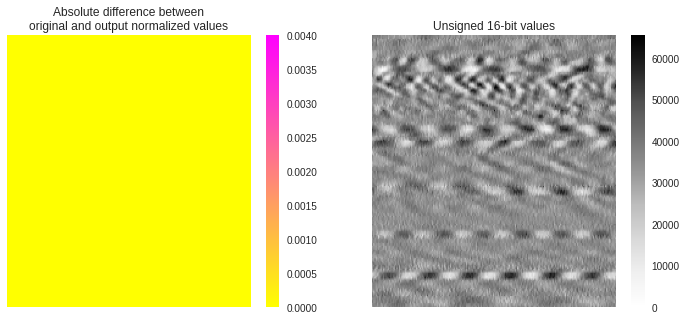

In [45]:
import matplotlib.pyplot as plt
print('Mean difference:',numpy.mean(abs(image-data_norm)))
plt.style.use('seaborn')
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
img = ax1.imshow(abs(image-data_norm),aspect='auto',cmap='spring_r',vmax=4e-3)
plt.colorbar(img,ax=ax1)
ax1.set_title('Absolute difference between\noriginal and output normalized values')
ax1.axis("off")
img = ax2.imshow(data_uint16,aspect='auto')
plt.colorbar(img,ax=ax2)
ax2.set_title('Unsigned 16-bit values')
ax2.axis("off")
plt.show()

### 16-bit consistent amplitudes

While the features found in the data are kept intact after normalizing the regions, the knowledge regarding the change in amplitude for a given type of signal between different regions is lost. However, this could be an important information to keep as one might one to differentiate faint from bright features. The information from the original data array can be kept intact as an image by converting the original data, which is in signed 16-bit format with values ranging from −32,768 to 32,767, to unsigned 16-bit format ranging from 0 to 65,536. This can be achieved by shifting the signed values by a positive offset of 32,768.

In [ ]:
import numpy
from PIL import Image
info = numpy.iinfo(numpy.int16)
print(info)
img = numpy.uint16(data+abs(info.min))
print(data_uint16)

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

[[39413 38739 38456 ... 37959 40582 37357]
 [39590 37605 36754 ... 39200 41114 35124]
 [39235 34273 34699 ... 41575 42815 32537]
 ...
 [34876 36010 36719 ... 36294 37180 33068]
 [35266 37038 36223 ... 35372 41043 31154]
 [30729 37463 35797 ... 35478 38775 32005]]


Below is what the saved PNG image would look like, the values are unsigned 16-bit integers. We purposedly scaled the color from 0 to the maximum value for 16-bit unsigned intergers, that is 65,536. The image is obviously very faint.

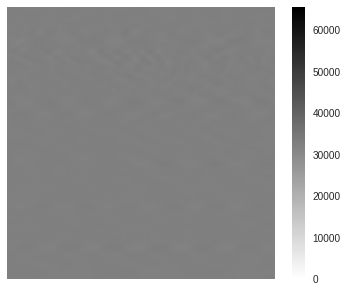

In [ ]:
import matplotlib.image as mpimg
plt.style.use('seaborn')
plt.figure(figsize=(6,5))
plt.imshow(img,aspect='auto',cmap='binary',vmin=0,vmax=65536)
plt.colorbar()
plt.axis("off")
plt.show()

## Load/save training images

There are two types of loading, from the raw DAS data or from an image file. If loading from a file, one can either use the OpenCV or PIL library to do so.

### JPG vs. PNG format

Assuming we are saving the data as 8-bit integer images. We can use the `Image` class from the `PIL` Python package to save the array into a JPG image. However, as we show below, when reading back to saved JPG image and convert it into a Numpy array, we find different values than the original array. It seems that, although the JPG format should be able to store values from 0 to 255 (both edges included), it actually fails to recover those extreme values.

In [ ]:
from PIL import Image
print('min/max of input 8-bit data:',data_uint8.min(),data_uint8.max())
print(data_uint8)
img = Image.fromarray(data_uint8)
img.save('8-bit.jpg')
image = numpy.array(Image.open('8-bit.jpg'))
print('\nmin/max of output 8-bit image:',image.min(),image.max())
print(image)

min/max of input 8-bit data: 0 255
[[153 150 149 ... 147 157 145]
 [154 146 143 ... 152 159 136]
 [152 133 135 ... 161 166 126]
 ...
 [135 140 142 ... 141 144 128]
 [137 144 140 ... 137 159 121]
 [119 145 139 ... 138 150 124]]

min/max of output 8-bit image: 1 253
[[154 148 154 ... 132 174 139]
 [149 148 148 ... 150 164 135]
 [153 137 130 ... 167 150 138]
 ...
 [145 128 144 ... 141 141 124]
 [128 144 144 ... 140 154 122]
 [119 161 139 ... 133 160 123]]


In order to avoid the data loss found with the JPG format, we will now use PNG format, which can store 16-bit integer and will therefore ensure to keep all the 8-bit integer values intact during reading data extraction of the images.

In [ ]:
from PIL import Image
print('min/max of input 8-bit data:',data_uint8.min(),data_uint8.max())
print(data_uint8)
img = Image.fromarray(data_uint8)
img.save('8-bit.png')
image = numpy.array(Image.open('8-bit.png'))
print('\nmin/max of output 8-bit image:',image.min(),image.max())
print(image)

min/max of input 8-bit data: 0 255
[[153 150 149 ... 147 157 145]
 [154 146 143 ... 152 159 136]
 [152 133 135 ... 161 166 126]
 ...
 [135 140 142 ... 141 144 128]
 [137 144 140 ... 137 159 121]
 [119 145 139 ... 138 150 124]]

min/max of output 8-bit image: 0 255
[[153 150 149 ... 147 157 145]
 [154 146 143 ... 152 159 136]
 [152 133 135 ... 161 166 126]
 ...
 [135 140 142 ... 141 144 128]
 [137 144 140 ... 137 159 121]
 [119 145 139 ... 138 150 124]]


### RGB vs. Grayscale

We can use one of the Matplotlib colormaps from [this page](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) and convert the raw normalized data into colored images. For instance, below we show how we use the ``rainbow`` colormap to create a RGB version of the DAS data region.

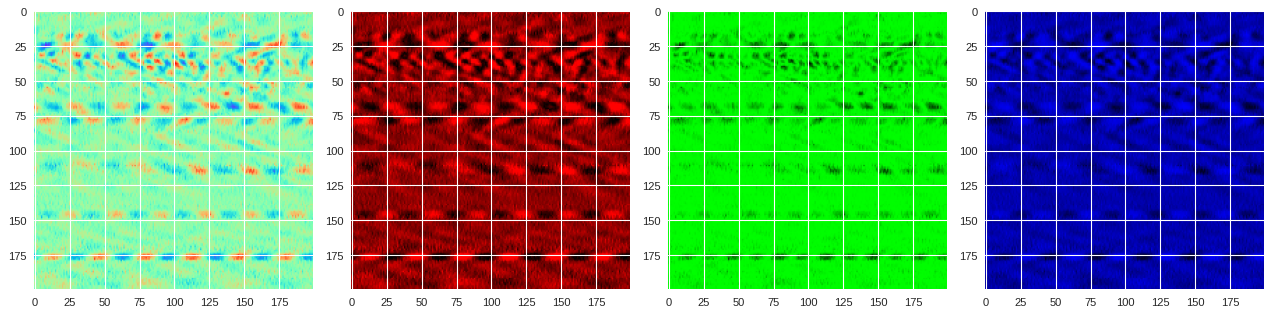

In [14]:
from matplotlib import cm
img = Image.fromarray(numpy.uint8(cm.rainbow(data_norm)*255)).convert("RGB")
img.save('rgb.png')
img = numpy.array(Image.open('rgb.png'))
plt.style.use('seaborn')
fig, ax = plt.subplots(1,4,figsize=[16,4],dpi=80)
ax[0].imshow(img)
for i_channel in range(3):
  temp = numpy.zeros(img.shape, dtype='uint8')
  temp[:,:,i_channel] = img[:,:,i_channel]
  ax[i_channel+1].imshow(temp)
plt.tight_layout()
plt.show()

Each pixel on the image will therefore have a particular value for the red, green and blue filters, which is not necessarily the same value. For instance, here are the values for each filter for the first top left pixel:

In [ ]:
print(img[0,0])

[178 242 149]


Here we show how saved (colored or not) PIL images look like when converting them into RGB or Grayscale images. There are two ways to save black and white images. One approach is to keep the original normalized values (see ``img1`` variable) and the other is to use a binary colormap (see ``img2`` variable). As shown before, a different colormap can be used to generate a colored image (see ``img3`` variable). When loading the images, one can either load them as single channel grayscale image using the "L" conversion format, or as 3-channel RGB images using the "RGB" conversion format. Several things can be noticed in the figures below:

*   For images saved in grayscale (`img1` and `img2`), the values of the pixels are the same whether the image is loaded as grayscale or RGB image, the only difference being that the loaded RGB image has 3 times the same value for each pixel (one for each channel) while the L (grayscale) image has only 1-channel values. This is why the RGB version can look a bit darker than the L version because the same values are stacked 3 times.

*   If the image is saved in RGB format, the values for each pixel will be different whether the image is loaded as RGB or L format. The documentation regarding the conversion can be found [in this page](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert) and shows how the grayscale single channel values are calculated from the R, G and B filtered values. Depending on the original RGB colormap used for saving, the loaded black and white image can be less detailed than if the image were saved as binary.

1st pixel value(s): 153 (L) [153 153 153] (RGB)


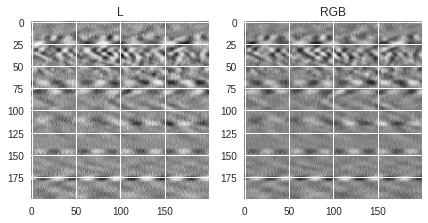

1st pixel value(s): 102 (L) [102 102 102] (RGB)


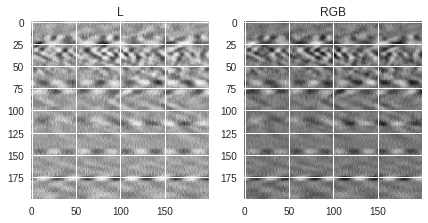

1st pixel value(s): 212 (L) [178 242 149] (RGB)


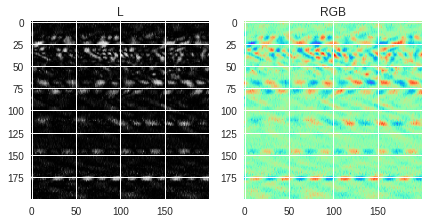

In [38]:
# Saving data in 3 different ways
img1 = Image.fromarray(numpy.uint8(data_norm*255))
img2 = Image.fromarray(numpy.uint8(cm.binary(data_norm)*255))
img3 = Image.fromarray(numpy.uint8(cm.rainbow(data_norm)*255))
# Looping over each saved PIL image
for img in [img1,img2,img3]:
  # Loading the image in grayscale and RGB formats
  grayscale = numpy.array(img.convert("L"))
  rgb_image = numpy.array(img.convert("RGB"))
  print('1st pixel value(s):',grayscale[0,0],'(L)',rgb_image[0,0],'(RGB)')
  # Plot both loaded images
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,5))
  ax1.imshow(grayscale)
  ax1.set_title('L')
  ax2.imshow(rgb_image)
  ax2.set_title('RGB')
  plt.show()

### OpenCV vs. PIL

The difference between OpenCV and PIL is in how the channels are ordered. While the PIL library returns images in (R, G, B) format whereas OpenCV returns images in (B, G, R) format. Below, we show how to load the images using both methods. Loading images with the PIL library is the most straightforward approach where the output can be read through a `numpy.array`. If loaded with OpenCV, the 3 channels (originally ordered as B, G and R) from the last dimension of the array should be permuted to reflect the R, G, B standard ordering.

In [23]:
import numpy,cv2
from PIL import Image
pil_img = numpy.array(Image.open('./rgb.png'),dtype=numpy.uint8)
print('1st pixel original RGB values on PIL ...',pil_img[0,0])
cv2_img = cv2.imread('./rgb.png')
print('Original output OpenCV values ..........',cv2_img[0,0])
cv2_img = cv2_img[:,:,[2,1,0]]
print('Permuted OpenCV output channels ........',cv2_img[0,0])

1st pixel original RGB values on PIL ... [178 242 149]
Original output OpenCV values .......... [149 242 178]
Permuted OpenCV output channels ........ [178 242 149]


### Loading from data

In [ ]:
import numpy
from torchvision import transforms
data_norm = (data-data.min())/(data.max()-data.min())
uint8_max = numpy.iinfo(numpy.uint8).max
image = numpy.uint8(data_norm*uint8_max)
image = Image.fromarray(image)
image = transforms.ToTensor()(image.convert("L")).view(1,1,*image.size)
print(image)

tensor([[[[0.6000, 0.5882, 0.5843,  ..., 0.5765, 0.6157, 0.5686],
          [0.6039, 0.5725, 0.5608,  ..., 0.5961, 0.6235, 0.5333],
          [0.5961, 0.5216, 0.5294,  ..., 0.6314, 0.6510, 0.4941],
          ...,
          [0.5294, 0.5490, 0.5569,  ..., 0.5529, 0.5647, 0.5020],
          [0.5373, 0.5647, 0.5490,  ..., 0.5373, 0.6235, 0.4745],
          [0.4667, 0.5686, 0.5451,  ..., 0.5412, 0.5882, 0.4863]]]])
